In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 471.8 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a43302006a3088bbe45ec82537db82d7b78f36a405fb220f0562214a75f62897
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizerFast, BertModel, AdamW, BertConfig, BertPreTrainedModel, BertForTokenClassification
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm

import warnings
from transformers import logging

warnings.simplefilter(action='ignore', category=FutureWarning)
logging.set_verbosity_error()

In [41]:
config = {}
config['MAX_LEN'] = 256
# config['datasplit'] = 0.8
config['batch_size'] = 32
config['epochs'] = 20
config['lr'] = 5e-8
config['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [4]:
# train annotated
dict_train_word = {
        'word': [],
        'annotated': [],
    }
with open( 'train_annotated.txt', 'r', encoding='UTF-8') as f:
    lines = f.readlines()
    for items in lines:
        items = re.sub('\n', '',items)
        words = items.split(' ')
        dict_train_word['word'].append(words[0])
        dict_train_word['annotated'].append(words[1])
df_train_word = pd.DataFrame(dict_train_word)

# test annotated
dict_test_word = {
        'word': [],
        'annotated': [],
    }
with open( 'test_annotated.txt', 'r', encoding='UTF-8') as f:
    lines = f.readlines()
    for items in lines:
        items = re.sub('\n', '',items)
        words = items.split(' ')
        dict_test_word['word'].append(words[0])
        dict_test_word['annotated'].append(words[1])
df_test_word = pd.DataFrame(dict_test_word)

# train corpus
df_train_article = pd.read_csv("train_revised.csv")
# test corpus
df_test_article = pd.read_csv("test_revised.csv")

train article length


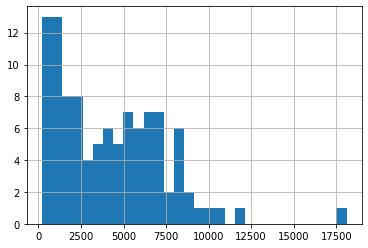

In [5]:
train_article_len = [len(i) for i in df_train_article['content']]
pd.Series(train_article_len).hist(bins = 30)
print("train article length")

test article length


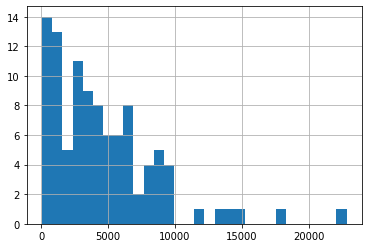

In [6]:
test_article_len = [len(i) for i in df_test_article['content'] if type(i) != float] # df_test_article['content'][73] == Nan
pd.Series(test_article_len).hist(bins = 30)
print("test article length")

## Data preprocessing

In [7]:
def split_sentences(df_article):   

    httpRegex = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

    sentences = []
    sent_len = []
    for idx in range(len(df_article['content'])):
        article = df_article.iloc[idx, 1]
        if(type(article) == float):
            continue
        # 去除網址
        search_res = httpRegex.search( article )
        if search_res:
            article = re.sub(search_res.group(0) , '', article)
        lines = article.split('\n')
        # print(sentences)
        for line in lines:
            if(len(line)>250):
                sent = line.split('。')
                sent_len.extend([len(i) for i in sent]) # if type(i) != float
                sentences.extend([len(i) for i in sent])
            else:
                sent_len.append(len(line))
                sentences.append(line)
    return sentences, sent_len

In [8]:
train_sent, train_sent_len = split_sentences(df_train_article)
test_sent, test_sent_len = split_sentences(df_test_article)

In [9]:
def select_label_sentence(sentences, dict_word):    
    sent_set = set()
    for sent in sentences:
        if(type(sent) != str):
            continue
        for word in dict_word['word']:        
            if(word in sent):
                sent_set.add(sent)
                break
    return list(sent_set)

train size: 2675
train labels: 693


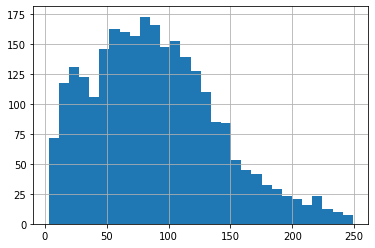

In [10]:
train_sentences = select_label_sentence(train_sent, dict_train_word)
pd.Series([len(i) for i in train_sentences]).hist(bins = 30)
print("train size:", len(train_sentences))
print("train labels:", len(dict_train_word['word']))

test size: 2835
train labels: 822


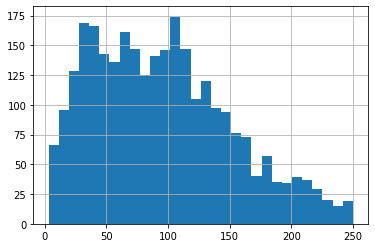

In [11]:
test_sentences = select_label_sentence(test_sent, dict_test_word)
pd.Series([len(i) for i in test_sentences]).hist(bins = 30)
print("test size:", len(test_sentences))
print("train labels:", len(dict_test_word['word']))

In [12]:
print('==== Loading BertTokenizerFast ====')
model_name = "hfl/chinese-bert-wwm-ext"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

==== Loading BertTokenizerFast ====


Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [13]:
def form_labels(sentences, df_word):

    input_ids = []
    input_masks = []
    matched_words = []    
    label = []
    # unmatched_counter = 0
    
    for sent in tqdm(sentences):    
        encoded_text = tokenizer.encode_plus(
            sent,
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            max_length = 256,
            pad_to_max_length =True,
            return_token_type_ids = False,
            return_attention_mask = True,
        )
        tokens = encoded_text.get('input_ids')
        input_ids.append(tokens)
        input_masks.append(encoded_text.get('attention_mask'))
        
        z = np.array(['O-O'] * len(tokens)) # Create final label == len(tokens) of each sentence
        z[:] = 'O'
        
        matched_keywords = 0 # Initially no kword matched    
        
        for word_id in range(len(df_word['word'])):
            word = df_word.iloc[word_id, 0]
            if(word in sent): #This is to first check if the keyword is in the text and then go ahead
                
                if(df_word.iloc[word_id, 1] == 'O'): # no need to annotate, but we add to matched_words
                    matched_keywords += 1
                    if matched_keywords >1:
                        label[-1] = (z.tolist())
                        matched_words[-1].append(word)
                    else:
                        label.append(z.tolist())
                        matched_words.append([word])
                else:
                    encoded_word = tokenizer.encode_plus(
                        word,
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                        return_token_type_ids = False,
                        return_attention_mask = False,
                    )
                    word_tokens = encoded_word.get('input_ids')

                    for i in range(len(tokens)):
                        if tokens[i: (i + len(word_tokens))] == word_tokens:
                            matched_keywords += 1

                            if (len(word_tokens) == 1):
                                # z[i] = 'B'
                                z[i] = 'B-' + df_word.iloc[word_id, 1][0]
                            else:
                                z[i] = 'B-' + df_word.iloc[word_id, 1][0]
                                z[(i+1) : (i+ len(word_tokens))] = 'I-' + df_word.iloc[word_id, 1][0]

                            if matched_keywords >1:
                                label[-1] = (z.tolist())
                                matched_words[-1].append(word)
                            else:
                                label.append(z.tolist())
                                matched_words.append([word])
        if(matched_keywords==0):
            print("unmatched")
            # unmatched_counter += 1
    # print("unmatched sentences count:", unmatched_counter)                
    return input_ids, input_masks, matched_words, label

In [14]:
train_ids, train_masks, train_matchedwords, train_labels = form_labels(sentences=train_sentences, df_word = df_train_word)
test_ids, test_masks, test_matchedwords, test_labels = form_labels(sentences=test_sentences, df_word = df_test_word)

100%|██████████| 2835/2835 [01:17<00:00, 36.80it/s]


## Showing data after labeling

In [15]:
# show training data
train_df = pd.DataFrame({'sentences': train_sentences, 
                        'word': train_matchedwords, 
                        'label':train_labels})
train_df

,sentences,word,label
0,据报道，支援上海的各种物资达2500万吨，平均每人将近一吨，然而……每人收到有多少公斤呢？物...,[有多少],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,随着这轮疫情爆发，孙波成了运送保供物资的司机，在核酸阳性之后，他在驾驶室里待了6天等来转运。...,"[保供物资, 驾驶室里, 核酸阳性, 建国东路, 疫情爆发]","[O, O, O, O, O, B-G, I-G, I-G, I-G, O, O, O, O..."
2,王玉还记得第一次发工资时的喜悦，记得自己穿上高跟鞋时候的兴奋，走在大街上，看着那些穿着“土里...,[大街上],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,尤其今年，新冠疫情突然多点爆发，各地出台政策加强管控。老吕说，他从3月4号到4月9号，不到一...,[新冠疫情],"[O, O, O, O, O, O, B-G, I-G, I-G, I-G, O, O, O..."
4,这段时间，汪清月每天凌晨 4 点多起床，驱车赶到二十公里以外的单位，6 点半前准备好所有核酸...,[这段时间],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
2670,在经济方面，54.54%的困境农民工家庭认为其困难与疫情直接相关，主要是因疫情造成的工作量减...,"[收入减少, 困境农民工, 因疫情]","[O, O, O, O, O, O, O, O, O, O, O, O, B-L, I-L,..."
2671,到底找谁开复工证明,[复工证],"[O, O, O, O, O, O, B-G, I-G, I-G, O, O, O, O, ..."
2672,近日，新华社发布《北蔡！北蔡！》系列视频，揭露了上海抗疫故事的一角。在第一期视频就曝出，北蔡...,[社区卫生服务中心],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2673,根据产业分析指出，并非所有产业类型的劳工都收到同样的影响，而是那些本来就领取较低工资、受到比...,[不平等],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [16]:
# show testing data
test_df = pd.DataFrame({'sentences': test_sentences, 
                        'word': test_matchedwords, 
                        'label':test_labels})
test_df

,sentences,word,label
0,在江一朋的印象里，从未听说谁的绩效能被打到这么低。“因为绩效是存在校准的，+2（字节跳动通用...,"[相较于, 江一朋, 直属领导, 字节跳动]","[O, O, B-N, I-N, I-N, O, O, O, O, O, O, O, O, ..."
1,根据致诚中心的研究，在传统模式中，消费者电话点餐后，餐馆自行雇用员工配送，而进入平台经济时代...,"[致诚中心, 外卖平台, 外卖平台, 研究中心, 外卖员, 外卖员, 调研报告]","[O, O, O, B-N, I-N, I-N, I-N, O, O, O, O, O, O..."
2,1980-1990年代，职业学校软硬件都一般，但因为技术工人地位高、出路好，学生家长都抢着去...,"[职业学校, 学生们, 背景下, 技术工人, 技术工人, 毕业后]","[O, O, O, O, O, O, O, B-L, I-L, I-L, I-L, O, O..."
3,我们只是希望，明年还能看到它开。,[能看到],"[O, O, O, O, O, O, O, O, O, O, O, B-G, I-G, I-..."
4,她多年上访未果，无望之下在2017年下定决心将村集体告上法庭。求助到我们千千所，我们代理了她...,"[村集体, 千千所]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
2830,女性最明显的劣势就是体能，田蕾想了许多办法，尽量用时长来弥补差距。来北京后，她特地剪掉长发，...,"[来北京, 女骑手]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2831,“之前在食品厂工作过，流水线的工作就像拨浪鼓一样，一个动作在重复做。每天早上六点半就要起床上...,"[每天早上, 每天都, 这是一个]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2832,记者注意到，此次北京两家公司因违法延长14名和44名劳动者工作时间仅被罚款7000元和176...,"[两家公司, 工作时间, 工作时间, 注意到]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2833,假如真的是这样的话，想要从社会公平的角度来提升职业教育的地位，就不太可行了。,[职业教育],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [17]:
tags_2_idx = {'O': 0 , 'B-G': 1, 'I-G': 2, 'B-L':3, 'I-L': 4, 'B-N':5, 'I-N':6 }
idx_2_tags = {v: k for k, v in tags_2_idx.items()}
label_class_name = ['General', 'Labor', 'Name']
train_labels_id = [list(map(tags_2_idx.get, lab)) for lab in train_labels]
test_labels_id = [list(map(tags_2_idx.get, lab)) for lab in test_labels]

In [18]:
train_data = TensorDataset(torch.tensor(train_ids), torch.tensor(train_masks), torch.tensor(train_labels_id))
train_dataloader = DataLoader(train_data, batch_size = config['batch_size'])
test_data = TensorDataset(torch.tensor(test_ids), torch.tensor(test_masks), torch.tensor(test_labels_id))
test_dataloader = DataLoader(test_data, batch_size = config['batch_size'])

## Model

In [19]:
class BertSeqTagging(BertPreTrainedModel):
    def __init__(self, config, num_class):
        super().__init__(config)
        self.num_labels = num_class
        self.bert = BertModel.from_pretrained(       
            'hfl/chinese-bert-wwm-ext',
            num_labels = num_class,
            output_attentions = False,
            add_pooling_layer=False,
        )
        
        # 鎖定預訓練模型參數
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.config = self.bert.config
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_class)        
        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )        
        # outputs[0] => outputs.last_hidden_state
        # outputs[1] => outputs.pooler_output # if add_pooling_layer = True
        sequence_output = outputs.last_hidden_state # outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs

In [20]:
def train_loop(model, dataloader, optimizer):       
    model.train() # Set our model to training mode (as opposed to evaluation mode)
    total_loss = 0 # Reset total loss for this epoch.
    #total_acc = 0
    pred_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
    true_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
        
    with tqdm(dataloader, unit='batch', desc='Train') as tqdm_loader: # desc: Prefix for the progressbar.                  
        for step, batch in enumerate(tqdm_loader):                               
            batch = tuple(t.to(device = config['device']) for t in batch) # Add batch to GPU
            input_ids, input_mask, labels = batch # Unpack the inputs from our dataloader      
            # Clear out the gradients (by default they accumulate) 
            optimizer.zero_grad()                
            outputs = model(input_ids, token_type_ids=None, attention_mask = input_mask, labels = labels) # Forward pass for multilabel classification
            loss = outputs[0]
            pred = outputs[1] # torch.Size([batch_size, seq_length, num_class])
            # Compute gradients and update weights
            loss.backward() # Backward pass # 計算梯度
            optimizer.step()  # Update parameters and take a step using the computed gradient (call .step() to initiate gradient descent)          
            # Update tracking variables
            # 1. loss
            now_loss = loss.item() # 同loss.detach().item()
            total_loss += now_loss
            # 2. accuracy
            predictions = np.argmax(pred.detach().to('cpu').numpy(), axis = 2)
            actual = labels.to('cpu').numpy()
            #acc = accuracy_score([list(map(idx_2_tags.get, lab)) for lab in actual], [list(map(idx_2_tags.get, lab)) for lab in predictions])
            #total_acc += acc
            pred_labels_id = np.concatenate((pred_labels_id, predictions), axis = 0)
            true_labels_id = np.concatenate((true_labels_id, actual), axis = 0)
            tqdm_loader.set_postfix( {'avg_loss':f'{total_loss/(step+1):.4f}'}) # ,'avg_acc':f'{total_acc/(step+1):.4f}'
    # convert back to BIO
    pred_labels = [list(map(idx_2_tags.get, lab)) for lab in pred_labels_id]
    true_labels = [list(map(idx_2_tags.get, lab)) for lab in true_labels_id]
    # performance & metrics 
    avg_loss = total_loss / len(dataloader) # len(train_dataloader) == total step number
    avg_acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division = 1)
    recall = recall_score(true_labels, pred_labels, zero_division = 1)        
    f1 = f1_score(true_labels, pred_labels, zero_division = 1)
    # macro_f1 = f1_score(true_labels, pred_labels, average='macro')
    # micro_f1 = f1_score(true_labels, pred_labels, average='micro')
    # weighted_f1 = f1_score(true_labels, pred_labels, average='weighted')
    print(f"  Average training loss: {avg_loss:.4f}")
    print(f"  Training Accuracy:     {avg_acc:.4f}" )
    print(f"  Training Precision:    {precision:.4f}" )
    print(f"  Training Recall:       {recall:.4f}" )
    print(f"  Training F1-score:     {f1:.4f}" )
    print('  Each class F1:', ''.join('{}: {:.4f} '.format(*k) for k in enumerate( f1_score(true_labels, pred_labels, average = None, zero_division = 1) )) )
    return avg_loss, f1

In [31]:
@torch.no_grad()
def test_loop(model, dataloader, optimizer, report = False):
    model.eval()
    total_loss = 0
    #total_acc = 0
    pred_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
    true_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])

    with torch.no_grad():
        with tqdm(dataloader, unit='batch', desc='Test') as tqdm_loader:
            for step, batch in enumerate(tqdm_loader):
                batch = tuple(t.to(device = config['device']) for t in batch) # Add batch to GPU
                input_ids, input_mask, labels = batch # Unpack the inputs from our dataloader  
                outputs = model(input_ids, token_type_ids=None, attention_mask = input_mask, labels = labels)
                loss, pred = outputs[0], outputs[1]                            
                # Update tracking variables
                # 1. loss            
                now_loss = loss.item()
                total_loss += now_loss
                # 2. accuracy
                predictions = np.argmax(pred.detach().to('cpu').numpy(), axis = 2)
                actual = labels.to('cpu').numpy()
                # acc = accuracy_score([list(map(idx_2_tags.get, lab)) for lab in actual], [list(map(idx_2_tags.get, lab)) for lab in predictions])
                # total_acc += acc
                pred_labels_id = np.concatenate((pred_labels_id, predictions), axis = 0)
                true_labels_id = np.concatenate((true_labels_id, actual), axis = 0)
                    
                tqdm_loader.set_postfix({'avg_loss':f'{total_loss/(step+1):.4f}'}) # ,'avg_acc':f'{total_acc/(step+1):.4f}' 
    # convert back to BIO
    pred_labels = [list(map(idx_2_tags.get, lab)) for lab in pred_labels_id]
    true_labels = [list(map(idx_2_tags.get, lab)) for lab in true_labels_id]
    # performance & metrics 
    avg_loss = total_loss / len(dataloader)    
    avg_acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division = 1)
    recall = recall_score(true_labels, pred_labels, zero_division = 1)        
    f1 = f1_score(true_labels, pred_labels, zero_division = 1)
    print(f"  Average training loss: {avg_loss:.4f}")
    print(f"  Testing Accuracy:     {avg_acc:.4f}" )
    print(f"  Testing Precision:    {precision:.4f}" )
    print(f"  Testing Recall:       {recall:.4f}" )
    print(f"  Testing F1-score:     {f1:.4f}" )
    print('  Each class F1:', ''.join('{}: {:.4f} '.format(*k) for k in enumerate( f1_score(true_labels, pred_labels, average = None, zero_division = 1) )) )
    if(report == True):
        print(classification_report(true_labels, pred_labels))
    return avg_loss, f1

In [22]:
model = BertSeqTagging(BertConfig(), num_class = len(tags_2_idx))
model = model.to(config['device'])
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = config['lr'])
# optimizer = torch.optim.AdamW(model.parameters(), lr = config['lr'])

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

In [43]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = config['lr'])

## Training

In [44]:
train_history = { 'loss':[], 'f1': [], 'val_loss':[], 'val_f1': [] }
epochs = config['epochs']

for epoch in range(epochs):
    print('============= Epoch {:} / {:} =============\n'.format(epoch + 1, epochs))
    if((epoch+1) % 5 == 0):        
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
    print("LR =", optimizer.param_groups[0]['lr'])
    train_loss, train_f1 = train_loop(model, train_dataloader, optimizer)
    train_history.get('loss').append(train_loss)
    train_history.get('f1').append(train_f1)
#     test_loss, test_f1 = test_loop(model, test_dataloader, optimizer)
#     train_history.get('val_loss').append(test_loss)
#     train_history.get('val_f1').append(test_f1)
    print("")

============= Epoch 1 / 20 =============

LR = 5e-08


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2560]


  Average training loss: 0.2560
  Training Accuracy:     0.9801
  Training Precision:    0.0024
  Training Recall:       0.0003
  Training F1-score:     0.0005
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0035 

============= Epoch 2 / 20 =============

LR = 5e-08


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2558]


  Average training loss: 0.2558
  Training Accuracy:     0.9801
  Training Precision:    0.0050
  Training Recall:       0.0006
  Training F1-score:     0.0010
  Each class F1: 0: 0.0012 1: 0.0000 2: 0.0035 

============= Epoch 3 / 20 =============

LR = 5e-08


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2562]


  Average training loss: 0.2562
  Training Accuracy:     0.9801
  Training Precision:    0.0051
  Training Recall:       0.0006
  Training F1-score:     0.0010
  Each class F1: 0: 0.0000 1: 0.0013 2: 0.0035 

============= Epoch 4 / 20 =============

LR = 5e-08


Train: 100%|██████████| 84/84 [00:20<00:00,  4.03batch/s, avg_loss=0.2567]


  Average training loss: 0.2567
  Training Accuracy:     0.9801
  Training Precision:    0.0048
  Training Recall:       0.0006
  Training F1-score:     0.0010
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0069 

============= Epoch 5 / 20 =============

LR = 5e-09


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2558]


  Average training loss: 0.2558
  Training Accuracy:     0.9801
  Training Precision:    0.0024
  Training Recall:       0.0003
  Training F1-score:     0.0005
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0034 

============= Epoch 6 / 20 =============

LR = 5e-09


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2562]


  Average training loss: 0.2562
  Training Accuracy:     0.9801
  Training Precision:    0.0000
  Training Recall:       0.0000
  Training F1-score:     0.0000
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0000 

============= Epoch 7 / 20 =============

LR = 5e-09


Train: 100%|██████████| 84/84 [00:20<00:00,  4.03batch/s, avg_loss=0.2559]


  Average training loss: 0.2559
  Training Accuracy:     0.9801
  Training Precision:    0.0000
  Training Recall:       0.0000
  Training F1-score:     0.0000
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0000 

============= Epoch 8 / 20 =============

LR = 5e-09


Train: 100%|██████████| 84/84 [00:20<00:00,  4.01batch/s, avg_loss=0.2554]


  Average training loss: 0.2554
  Training Accuracy:     0.9801
  Training Precision:    0.0024
  Training Recall:       0.0003
  Training F1-score:     0.0005
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0035 

============= Epoch 9 / 20 =============

LR = 5e-09


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2557]


  Average training loss: 0.2557
  Training Accuracy:     0.9802
  Training Precision:    0.0099
  Training Recall:       0.0011
  Training F1-score:     0.0021
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0138 

============= Epoch 10 / 20 =============

LR = 5e-10


Train: 100%|██████████| 84/84 [00:20<00:00,  4.01batch/s, avg_loss=0.2565]


  Average training loss: 0.2565
  Training Accuracy:     0.9800
  Training Precision:    0.0000
  Training Recall:       0.0000
  Training F1-score:     0.0000
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0000 

============= Epoch 11 / 20 =============

LR = 5e-10


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2561]


  Average training loss: 0.2561
  Training Accuracy:     0.9801
  Training Precision:    0.0025
  Training Recall:       0.0003
  Training F1-score:     0.0005
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0034 

============= Epoch 12 / 20 =============

LR = 5e-10


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2561]


  Average training loss: 0.2561
  Training Accuracy:     0.9801
  Training Precision:    0.0046
  Training Recall:       0.0006
  Training F1-score:     0.0010
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0067 

============= Epoch 13 / 20 =============

LR = 5e-10


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2563]


  Average training loss: 0.2563
  Training Accuracy:     0.9801
  Training Precision:    0.0047
  Training Recall:       0.0006
  Training F1-score:     0.0010
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0069 

============= Epoch 14 / 20 =============

LR = 5e-10


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2558]


  Average training loss: 0.2558
  Training Accuracy:     0.9801
  Training Precision:    0.0050
  Training Recall:       0.0006
  Training F1-score:     0.0010
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0069 

============= Epoch 15 / 20 =============

LR = 5.000000000000001e-11


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2558]


  Average training loss: 0.2558
  Training Accuracy:     0.9801
  Training Precision:    0.0076
  Training Recall:       0.0009
  Training F1-score:     0.0015
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0103 

============= Epoch 16 / 20 =============

LR = 5.000000000000001e-11


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2559]


  Average training loss: 0.2559
  Training Accuracy:     0.9802
  Training Precision:    0.0024
  Training Recall:       0.0003
  Training F1-score:     0.0005
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0034 

============= Epoch 17 / 20 =============

LR = 5.000000000000001e-11


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2554]


  Average training loss: 0.2554
  Training Accuracy:     0.9801
  Training Precision:    0.0023
  Training Recall:       0.0003
  Training F1-score:     0.0005
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0034 

============= Epoch 18 / 20 =============

LR = 5.000000000000001e-11


Train: 100%|██████████| 84/84 [00:20<00:00,  4.02batch/s, avg_loss=0.2561]


  Average training loss: 0.2561
  Training Accuracy:     0.9801
  Training Precision:    0.0000
  Training Recall:       0.0000
  Training F1-score:     0.0000
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0000 

============= Epoch 19 / 20 =============

LR = 5.000000000000001e-11


Train: 100%|██████████| 84/84 [00:20<00:00,  4.03batch/s, avg_loss=0.2559]


  Average training loss: 0.2559
  Training Accuracy:     0.9801
  Training Precision:    0.0125
  Training Recall:       0.0014
  Training F1-score:     0.0026
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0173 

============= Epoch 20 / 20 =============

LR = 5.000000000000001e-12


Train: 100%|██████████| 84/84 [00:20<00:00,  4.03batch/s, avg_loss=0.2565]


  Average training loss: 0.2565
  Training Accuracy:     0.9801
  Training Precision:    0.0000
  Training Recall:       0.0000
  Training F1-score:     0.0000
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0000 



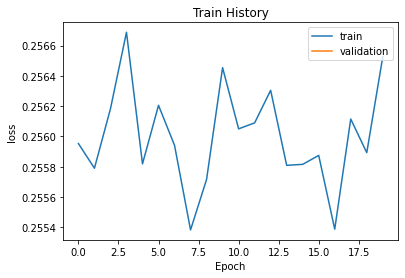

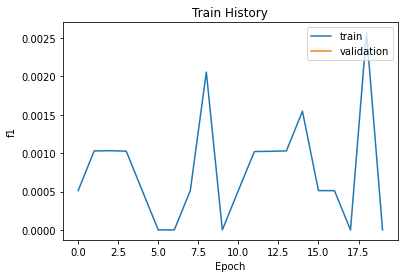

In [45]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history[train])
    plt.plot(train_history[validation])
    plt.title('Train History')
    plt.ylabel(train)        
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc='upper right')
    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'f1', 'val_f1')

In [46]:
_, _ = test_loop(model, test_dataloader, optimizer, True)

Test: 100%|██████████| 89/89 [00:21<00:00,  4.18batch/s, avg_loss=0.2958]


  Average training loss: 0.2958
  Testing Accuracy:     0.9770
  Testing Precision:    0.0000
  Testing Recall:       0.0000
  Testing F1-score:     0.0000
  Each class F1: 0: 0.0000 1: 0.0000 2: 0.0000 
              precision    recall  f1-score   support

           G       0.00      0.00      0.00      1624
           L       0.00      0.00      0.00      2115
           N       0.00      0.00      0.00       634

   micro avg       0.00      0.00      0.00      4373
   macro avg       0.00      0.00      0.00      4373
weighted avg       0.00      0.00      0.00      4373



In [25]:
torch.save(model, f'./model_finished.pth')